In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [7]:
import sys, os, pathlib
#os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project

torch.cuda.is_available()

True

In [8]:
%autoreload
ds = project.datasets.copdgene.COPDGeneDataset(
    data_root='/projectnb/batmanlab/haozhe/COPDGene'
)
ex = next(ds.examples(
    subjects=['16514P'],
    visit='Phase-1',
    variant='iso',
    state_pairs=[('EXP', 'INSP')]
))
print(ex)

Example(dataset='COPDGene', subject='16514P', variant='iso', paths={'ref_image': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/Images/16514P/Phase-1/RAW/16514P_EXP_STD_TEM_COPD.nii.gz'), 'fixed_source': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/Images/16514P/Phase-1/RAW/16514P_EXP_STD_TEM_COPD.nii.gz'), 'moving_source': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/Images/16514P/Phase-1/RAW/16514P_INSP_STD_TEM_COPD.nii.gz'), 'fixed_image': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/iso/16514P/Phase-1/images/16514P_EXP_STD_TEM_COPD.nii.gz'), 'moving_image': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/iso/16514P/Phase-1/images/16514P_INSP_STD_TEM_COPD.nii.gz'), 'binary_mask': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/iso/16514P/Phase-1/masks/16514P_EXP_STD_TEM_COPD/lung_combined.nii.gz'), 'region_mask': PosixPath('/projectnb/batmanlab/haozhe/COPDGene/iso/16514P/Phase-1/masks/16514P_EXP_STD_TEM_COPD/lung_regions.nii.gz'), 'surface_mesh': PosixPath('/projectnb/batm

In [9]:
def print_tensor_info(*args, **kwargs):
    for i, v in enumerate(args):
        print(f'{i}: {v.shape} {v.dtype} {v.device}')
    for k, v in kwargs.items():
        print(f'{k}: {v.shape} {v.dtype} {v.device}')

device = 'cuda'
dtype = torch.float32

image_nifti = nib.load(ex.paths['fixed_image'])
mask_nifti  = nib.load(ex.paths['region_mask'])  # Changed from 'fixed_mask'
disp_nifti  = nib.load(ex.paths['disp_field'])

mesh_io = meshio.read(ex.paths['volume_mesh'])  # Changed from 'fixed_mesh'

affine_array = image_nifti.affine
image_array  = image_nifti.get_fdata()
mask_array   = mask_nifti.get_fdata()
disp_array   = disp_nifti.get_fdata()

image_tensor = torch.as_tensor(image_array, dtype=dtype, device=device).unsqueeze(0)
mask_tensor  = torch.as_tensor(mask_array, dtype=dtype, device=device).unsqueeze(0)
disp_tensor  = torch.as_tensor(disp_array, dtype=dtype, device=device).permute(3,0,1,2)

print_tensor_info(image_tensor, mask_tensor, disp_tensor)

0: torch.Size([1, 368, 368, 269]) torch.float32 cuda:0
1: torch.Size([1, 368, 368, 269]) torch.float32 cuda:0
2: torch.Size([3, 368, 368, 269]) torch.float32 cuda:0


In [10]:
%autoreload
mm_to_m = 1e-3

points = project.core.transforms.world_to_voxel_coords(mesh_io.points, affine_array)
points = torch.as_tensor(points, dtype=dtype, device=device)

image_values = project.core.interpolation.interpolate_image(image_tensor, points)
u_obs_values = project.core.interpolation.interpolate_image(disp_tensor, points) * mm_to_m
rho_values = project.core.transforms.compute_density_from_ct(image_values)

print_tensor_info(image_values, u_obs_values, rho_values)

0: torch.Size([30493, 1]) torch.float32 cuda:0
1: torch.Size([30493, 3]) torch.float32 cuda:0
2: torch.Size([30493, 1]) torch.float32 cuda:0


In [6]:
pv_grid = pv.ImageData(
    dimensions=image_nifti.shape,
    spacing=np.linalg.norm(image_nifti.affine[:3,:3], axis=1)
)
pv_grid.point_data['CT'] = image_array.flatten(order='F')
pv_grid.point_data['mask'] = mask_array.flatten(order='F')
pv_grid

ImageData (0x15156f324ee0)
  N Cells:      36096652
  N Points:     36429056
  X Bounds:     0.000e+00, 3.670e+02
  Y Bounds:     0.000e+00, 3.670e+02
  Z Bounds:     0.000e+00, 2.680e+02
  Dimensions:   368, 368, 269
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

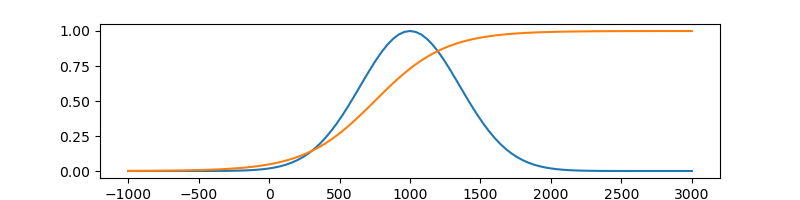

In [7]:
import matplotlib.pyplot as plt

def sigmoid(x, loc, scale):
    return 1 / (1 + np.exp(-(x - loc)/scale))

def gaussian(x, loc, scale):
    return np.exp(-((x - loc)/scale)**2)

x = np.linspace(-1000, 3000, 101)
g = gaussian(x, loc=1000, scale=500)
s = sigmoid(x, loc=750, scale=250)

fig, ax = plt.subplots(figsize=(8,2))
_ = ax.plot(x, g)
_ = ax.plot(x, s)

In [8]:
"""p = pv.Plotter()
p.add_mesh(pv_grid.contour(1000, scalars='CT'))
p.show(jupyter_backend='trame')"""

"p = pv.Plotter()\np.add_mesh(pv_grid.contour(1000, scalars='CT'))\np.show(jupyter_backend='trame')"

In [9]:
"""p = pv.Plotter()
p.add_volume(
    pv_grid, scalars='CT', cmap='jet', clim=(-1000, 3000),
    opacity=gaussian(np.linspace(-1000, 3000, 101), loc=300, scale=250)
)
p.show(jupyter_backend='trame')"""

"p = pv.Plotter()\np.add_volume(\n    pv_grid, scalars='CT', cmap='jet', clim=(-1000, 3000),\n    opacity=gaussian(np.linspace(-1000, 3000, 101), loc=300, scale=250)\n)\np.show(jupyter_backend='trame')"

In [8]:
pv_mesh = pv.from_meshio(mesh_io)
pv_mesh.point_data['CT']         = image_values.detach().cpu().numpy()
pv_mesh.point_data['rho']        = rho_values.detach().cpu().numpy()
pv_mesh.point_data['u_obs']      = u_obs_values.detach().cpu().numpy()
pv_mesh.point_data['u_obs_norm'] = np.linalg.norm(pv_mesh.point_data['u_obs'], axis=1)
pv_mesh

UnstructuredGrid (0x1514647129e0)
  N Cells:    158843
  N Points:   30493
  X Bounds:   -1.421e+02, 9.510e+01
  Y Bounds:   7.691e+01, 2.581e+02
  Z Bounds:   -2.653e+02, -5.244e+01
  N Arrays:   5

2025-11-05 17:08:49.503 (  48.716s) [    151582EEA400]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


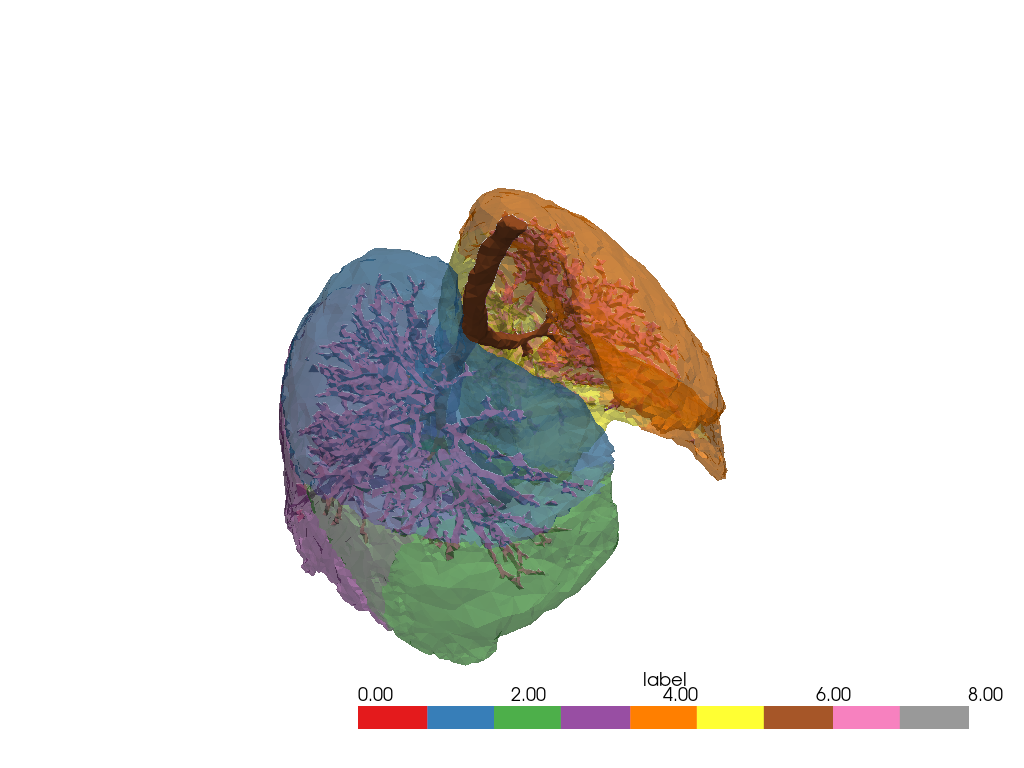

In [9]:
p = pv.Plotter()
p.add_mesh(
    pv_mesh.threshold((1, 5), scalars='label'),
    scalars='label',
    cmap='Set1',
    clim=(0, 8),
    opacity=0.5,
)
p.add_mesh(
    pv_mesh.threshold((6, 7), scalars='label'),
    scalars='label',
    cmap='Set1',
    clim=(0, 8),
    opacity=1.0
)
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

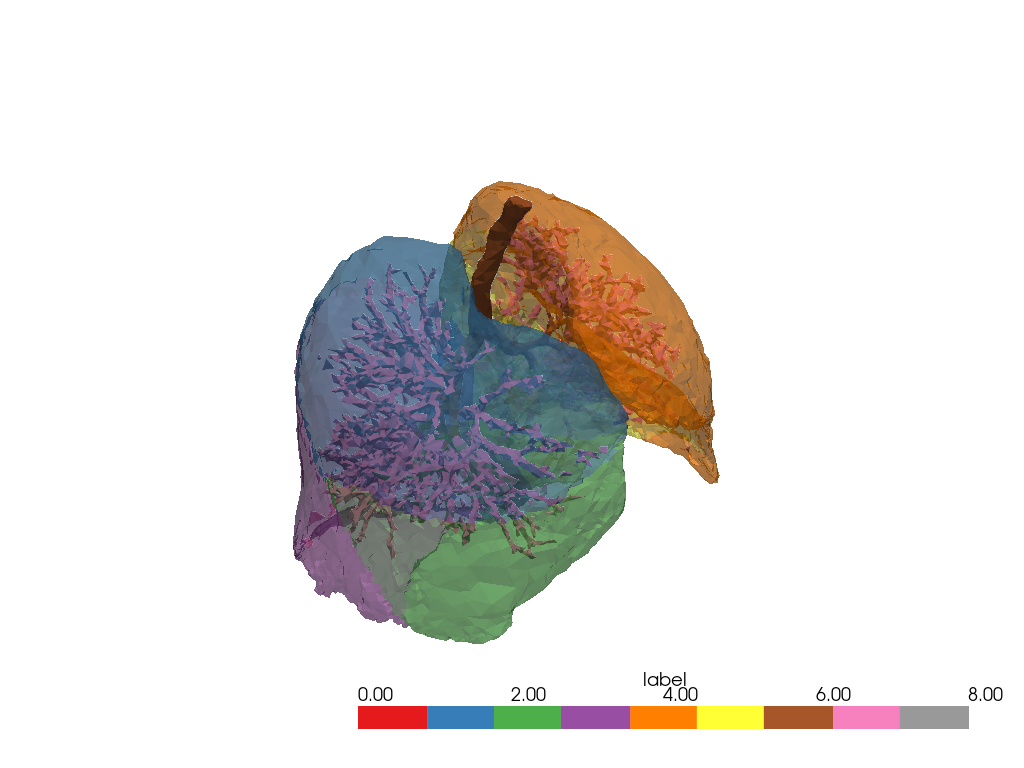

In [10]:
p = pv.Plotter()
pv_warped = pv_mesh.warp_by_vector('u_obs', factor=1/mm_to_m)
p.add_mesh(
    pv_warped.threshold((1, 5), scalars='label'),
    scalars='label',
    cmap='Set1',
    clim=(0, 8),
    opacity=0.5,
)
p.add_mesh(
    pv_warped.threshold((6, 7), scalars='label'),
    scalars='label',
    cmap='Set1',
    clim=(0, 8),
    opacity=1.0
)
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

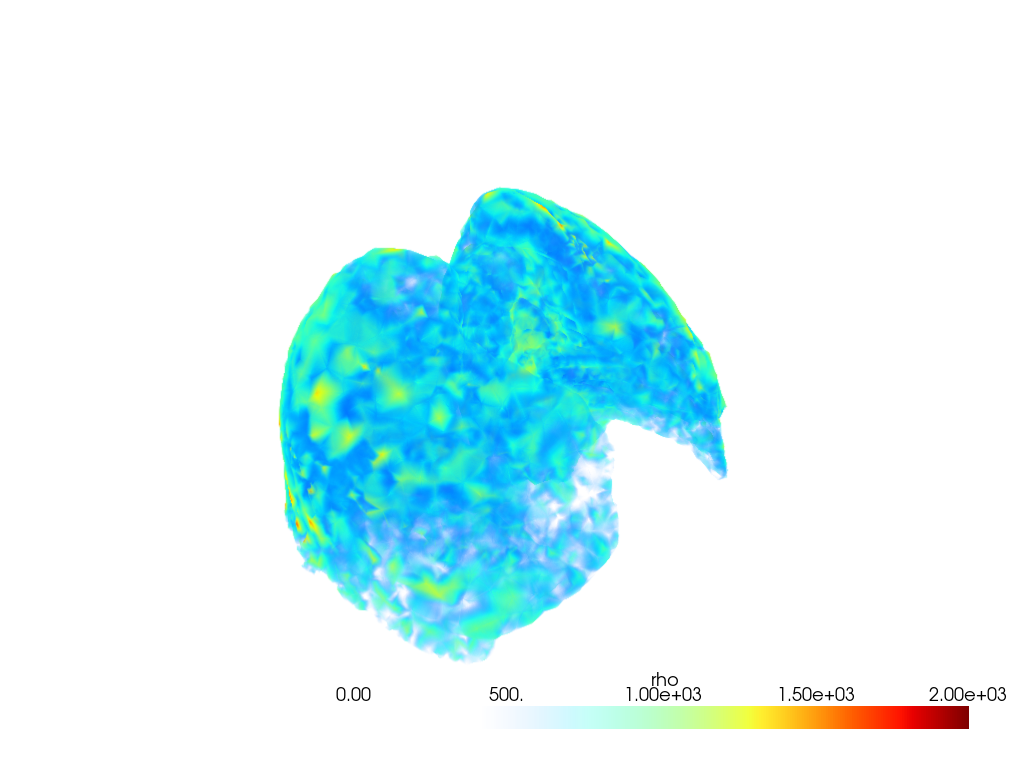

In [11]:
p = pv.Plotter()
p.add_volume(
    pv_mesh,
    scalars='rho',
    cmap='jet',
    clim=(0, 2000),
    opacity=[0.0, 0.05, 0.5, 0.95, 1.0],
)
p.show(jupyter_backend='static')

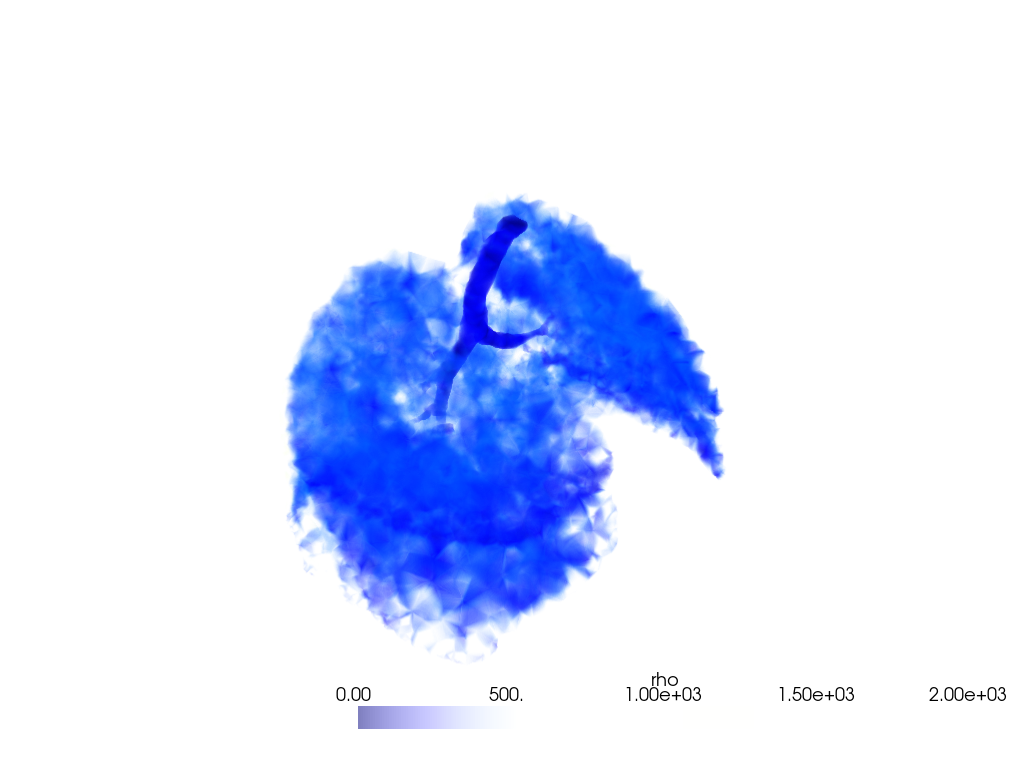

In [12]:
p = pv.Plotter()
p.add_volume(
    pv_mesh,
    scalars='rho',
    cmap='jet',
    clim=(0, 2000),
    opacity=[0.5, 0.01, 0.001, 0.0001, 0],
)
p.show(jupyter_backend='static')

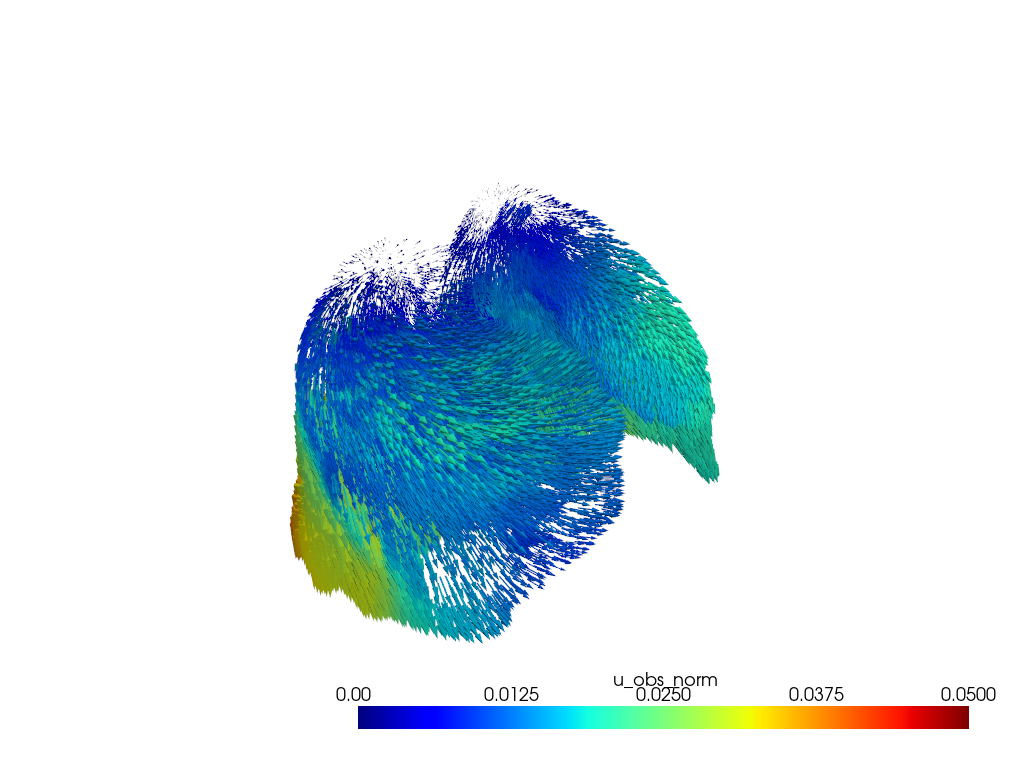

In [15]:
p = pv.Plotter()
arrows = pv_mesh.glyph(scale='u_obs', orient='u_obs', factor=1/mm_to_m)
p.add_mesh(arrows, scalars='u_obs_norm', cmap='jet', clim=(0, 0.05))
p.show(jupyter_backend='static')

# PDESolver interface

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
# ===== DATA LOADING FOR PDESolver interface =====
# This cell loads all necessary data to run from here onwards
# Run this after kernel restart to skip cells 1-15

import sys, os, pathlib

import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project

print(f"✓ CUDA available: {torch.cuda.is_available()}")

# Setup device and dtype
device = 'cuda'
dtype = torch.float32

# Load dataset and example
ds = project.datasets.copdgene.COPDGeneDataset(
    data_root='/projectnb/batmanlab/haozhe/COPDGene'
)
ex = next(ds.examples(
    subjects=['16514P'],
    visit='Phase-1',
    variant='ISO',
    state_pairs=[('EXP', 'INSP')]
))
print(f"✓ Loaded example: {ex.subject}")

# Load imaging data - 
image_nifti = nib.load(ex.paths['fixed_image'])
mask_nifti  = nib.load(ex.paths['region_mask'])
disp_nifti  = nib.load(ex.paths['disp_field'])
mesh_io = meshio.read(ex.paths['volume_mesh'])

affine_array = image_nifti.affine
image_array  = image_nifti.get_fdata()
mask_array   = mask_nifti.get_fdata()
disp_array   = disp_nifti.get_fdata()

# Create tensors
image_tensor = torch.as_tensor(image_array, dtype=dtype, device=device).unsqueeze(0)
mask_tensor  = torch.as_tensor(mask_array, dtype=dtype, device=device).unsqueeze(0)
disp_tensor  = torch.as_tensor(disp_array, dtype=dtype, device=device).permute(3,0,1,2)

print(f"✓ Image tensor: {image_tensor.shape}")
print(f"✓ Displacement tensor: {disp_tensor.shape}")

# Interpolate values at mesh points
mm_to_m = 1e-3
points = project.core.transforms.world_to_voxel_coords(mesh_io.points, affine_array)
points = torch.as_tensor(points, dtype=dtype, device=device)

image_values = project.core.interpolation.interpolate_image(image_tensor, points)
u_obs_values = project.core.interpolation.interpolate_image(disp_tensor, points) * mm_to_m
rho_values = project.core.transforms.compute_density_from_ct(image_values)

print(f"✓ Image values: {image_values.shape}")
print(f"✓ Displacement values: {u_obs_values.shape}")
print(f"✓ Density values: {rho_values.shape}")
print(f"✓ Mesh nodes: {mesh_io.points.shape[0]}")

# Create pyvista mesh for visualization (optional, but used in later cells)
pv_mesh = pv.from_meshio(mesh_io)
pv_mesh.point_data['CT']         = image_values.detach().cpu().numpy()
pv_mesh.point_data['rho']        = rho_values.detach().cpu().numpy()
pv_mesh.point_data['u_obs']      = u_obs_values.detach().cpu().numpy()
pv_mesh.point_data['u_obs_norm'] = np.linalg.norm(pv_mesh.point_data['u_obs'], axis=1)

print("\n" + "="*60)
print("✓ ALL DATA LOADED SUCCESSFULLY")
print("="*60)
print("\nReady variables:")
print("  - device, dtype, mm_to_m")
print("  - mesh_io (meshio object)")
print("  - image_values, u_obs_values, rho_values (torch tensors)")
print("  - pv_mesh (pyvista object)")
print("\nProceed to next cell to initialize Warp.")

✓ CUDA available: True
✓ Loaded example: 16514P
✓ Image tensor: torch.Size([1, 368, 368, 269])
✓ Displacement tensor: torch.Size([3, 368, 368, 269])
✓ Image values: torch.Size([12, 1])
✓ Displacement values: torch.Size([12, 3])
✓ Density values: torch.Size([12, 1])
✓ Mesh nodes: 12

✓ ALL DATA LOADED SUCCESSFULLY

Ready variables:
  - device, dtype, mm_to_m
  - mesh_io (meshio object)
  - image_values, u_obs_values, rho_values (torch tensors)
  - pv_mesh (pyvista object)

Proceed to next cell to initialize Warp.


In [3]:
import warp as wp
wp.init()

Warp 1.9.1 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX A6000" (44 GiB, sm_86, mempool enabled)
   Kernel cache:
     /usr4/ec523/haozhe/.cache/warp/1.9.1


In [4]:
%autoreload
solver = project.solvers.warp.WarpFEMSolver(mesh_io, reg_weight=5e-2, cg_tol=1e-5)
module = project.solvers.base.PDESolverModule(solver, rho_values, u_obs_values)

Module warp.fem.utils 3d55542 load on device 'cuda:0' took 1003.33 ms  (compiled)
Module warp.fem.geometry.tetmesh f560e73 load on device 'cuda:0' took 1369.88 ms  (compiled)
Module warp.fem.geometry.geometry.dyn.compute_cell_bounds_Tetmesh_f0f002c9 ecffb85 load on device 'cuda:0' took 401.74 ms  (compiled)
Module warp.fem.space.restriction.dyn.fill_element_node_indices_Tetmesh_Cells_Tetmesh_Tet_P1_Who_2c3e4ce3 2c6ed61 load on device 'cuda:0' took 300.53 ms  (compiled)
Module warp.fem.space.restriction d687b32 load on device 'cuda:0' took 300.52 ms  (compiled)
Module warp.fem.space.restriction.dyn.fill_element_node_indices_Tetmesh_BoundarySides_Tetmesh_Te_a9156ca0 20d653c load on device 'cuda:0' took 342.89 ms  (compiled)
Module project.solvers.warp.inner_form__itg_f4f8_uTrialFieldTetmesh_T_b41df497 ea8ec68 load on device 'cuda:0' took 1628.24 ms  (compiled)
Module warp.sparse 5149a50 load on device 'cuda:0' took 571.68 ms  (compiled)
Module warp.fem.dirichlet cb46b0e load on device 'c

In [5]:
theta_global = torch.zeros(1, dtype=dtype, device=device, requires_grad=True)
theta_local = torch.zeros_like(image_values, dtype=dtype, device=device, requires_grad=True)

def compute_E(theta_global, theta_local):
    log_E = theta_global + theta_local - theta_local.mean()
    return torch.pow(10, log_E)

def f_global(theta_global):
    E = compute_E(theta_global, theta_local)
    mu, lam = project.core.transforms.compute_lame_parameters(E, nu=0.4)
    return module.forward(mu, lam)

def f_local(theta_local):
    E = compute_E(theta_global, theta_local)
    mu, lam = project.core.transforms.compute_lame_parameters(E, nu=0.4)
    return module.forward(mu, lam)


In [6]:
def optimize(f, param, max_iter=100, tol=1e-3, eps=1e-12):

    optim = torch.optim.LBFGS(
        params=[param],
        lr=1.0,
        max_iter=10,
        history_size=10,
        line_search_fn='strong_wolfe'
    )   
    loss_prev = None
    grad_norm0 = None

    def closure():
        optim.zero_grad()
        loss = f(param)
        loss.backward()
        return loss

    for it in range(max_iter):
        loss = optim.step(closure)
    
        grad_norm = param.grad.norm()
        if grad_norm0 is None:
            grad_norm0 = max(grad_norm, eps)
    
        rel_grad_norm = grad_norm.item() / grad_norm0

        if loss_prev is None:
            rel_loss_delta = np.nan
        else:
            rel_loss_delta = abs(loss_prev - loss.item()) / abs(loss_prev)
    
        print(f'iteration {it} | loss = {loss.item():.4e} | rel_loss_delta = {rel_loss_delta:.4e} | rel_grad_norm = {rel_grad_norm:.4}', flush=True)

        if rel_loss_delta < tol or rel_grad_norm < tol:
            print('converged')
            break
    
        loss_prev = loss.item()


In [7]:
wp.config.quiet = True
optimize(f_global, theta_global)

iteration 0 | loss = 2.4328e-03 | rel_loss_delta = nan | rel_grad_norm = 1.084e-07
converged


In [8]:
theta_global

tensor([0.], device='cuda:0', requires_grad=True)

In [10]:
optimize(f_local, theta_local)

iteration 0 | loss = 2.4328e-03 | rel_loss_delta = nan | rel_grad_norm = 1.0
iteration 1 | loss = 2.4328e-03 | rel_loss_delta = 1.2442e-06 | rel_grad_norm = 1.0
converged


,count,mean,std,min,25%,50%,75%,max
0,12.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


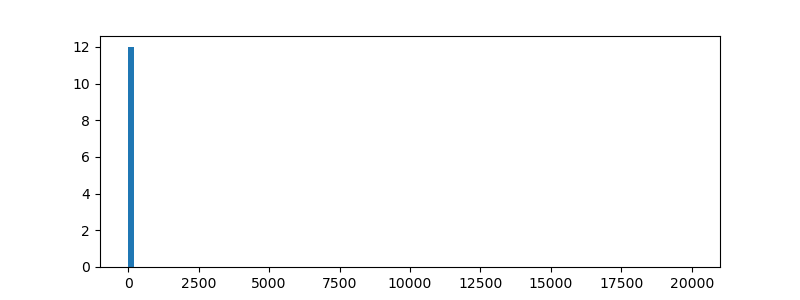

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(8,3))
a = compute_E(theta_global, theta_local).detach().cpu().numpy()
_ = ax.hist(a, bins=101, range=(0, 2e4))

pd.DataFrame(a).describe().T

In [10]:
pv_mesh.point_data['E'] = compute_E(theta_global, theta_local).detach().cpu().numpy()
pv_mesh.point_data['theta'] = theta_local.detach().cpu().numpy()
pv_mesh

UnstructuredGrid (0x14cf2058b6a0)
  N Cells:    16
  N Points:   12
  X Bounds:   3.548e+01, 8.898e+01
  Y Bounds:   1.130e+02, 2.409e+02
  Z Bounds:   -1.635e+02, -1.052e+02
  N Arrays:   7

In [83]:
p = pv.Plotter()
p.add_volume(
    pv_mesh,
    scalars='E',
    cmap='jet',
    clim=(0, 2e4),
    opacity=[0.1]
)
p.show() #jupyter_backend='static')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14616e16b750_10" src="https://ondemand.bridges2.…

# NVIDIA warp.fem development

In [24]:
import warp as wp
import warp.fem
import warp.optim.linear
wp.init()

In [7]:
geometry = wp.fem.Tetmesh(
    wp.array(mesh_io.cells_dict['tetra'], dtype=wp.int32),
    wp.array(mesh_io.points * mm_to_m,    dtype=wp.vec3f)
)

# integration domains
domain = wp.fem.Cells(geometry)
boundary = wp.fem.BoundarySides(geometry)

# function spaces
S = wp.fem.make_polynomial_space(geometry, degree=1, dtype=wp.float32)
V = wp.fem.make_polynomial_space(geometry, degree=1, dtype=wp.vec3f)

# trial and test functions
u_trial = wp.fem.make_trial(V, domain=domain)
v_test  = wp.fem.make_test(V, domain=domain)

ub_trial = wp.fem.make_trial(V, domain=boundary)
vb_test  = wp.fem.make_test(V, domain=boundary)

NameError: name 'mesh_io' is not defined

Physical model:
\begin{align}
    \nabla \cdot \sigma + \rho \mathbf{g} &= 0 \\
    \sigma &= 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I} \\
    \epsilon &= \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
\end{align}
Where:
\begin{align}
    \sigma: \Omega &\to \mathbb{R}^{3 \times 3} & \rho: \Omega &\to \mathbb{R} & \mathbf{g} &\in \mathbb{R}^3 \\
    \epsilon: \Omega &\to \mathbb{R}^{3 \times 3} & \mu: \Omega &\to \mathbb{R} & \lambda: \Omega &\to \mathbb{R} \\
    \mathbf{u}: \Omega &\to \mathbb{R}^3 \\
\end{align}

In [43]:
# physical fields and constants
u_obs_field = V.make_field()
u_sim_field = V.make_field()
r_field     = V.make_field()

mu_field  = S.make_field()
lam_field = S.make_field()
rho_field = S.make_field()

g = wp.vec3f([0, 0, -9.81])
I = wp.diag(wp.vec3f(1.0))

In [45]:
# assign dof values
mu_field.dof_values    = wp.from_torch(mu_values.contiguous(), dtype=wp.float32, requires_grad=True)
lam_field.dof_values   = wp.from_torch(lam_values.contiguous(), dtype=wp.float32, requires_grad=True)

rho_field.dof_values   = wp.from_torch(rho_values.contiguous(), dtype=wp.float32, requires_grad=True)
u_obs_field.dof_values = wp.from_torch(disp_values.contiguous(), dtype=wp.vec3f, requires_grad=True)

u_sim_field.dof_values.zero_()
u_sim_field.dof_values.requires_grad = True

r_field.dof_values.zero_()
r_field.dof_values.requires_grad = True

Weak formulation:
\begin{align}
    \nabla \cdot \sigma + \rho \mathbf{g} &= 0 \\
    -\int_\Omega \left( \nabla \cdot \sigma \right) \cdot \mathbf{v} \ d\mathbf{x} &= \int_\Omega \rho \mathbf{g} \cdot \mathbf{v} \ d\mathbf{x} \\
    \int_\Omega \sigma(\mathbf{u}) : \nabla \mathbf{v} \ d\mathbf{x} &= \int_\Omega \rho \mathbf{g}\cdot \mathbf{v} \ d\mathbf{x} + \int_{\partial \Omega} \left(\sigma \cdot \mathbf{n} \right) \cdot \mathbf{v} \ d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u}) : \epsilon(\mathbf{v}) \ d\mathbf{x} &= \int_\Omega \rho \mathbf{g}\cdot \mathbf{v} \ d\mathbf{x} + \int_{\partial \Omega} \mathbf{t} \cdot \mathbf{v} \ d\mathbf{s} \\
    \int_\Omega a(\mathbf{u},\mathbf{v}) \ d\mathbf{x} &= \int_\Omega L(\mathbf{v}) \ d\mathbf{x} \\
    \ldots \\
    \mathbf{K} \mathbf{u} &= \mathbf{f}
\end{align}

In [46]:
@wp.fem.integrand
def pde_bilinear_form(
    s: wp.fem.Sample,
    u: wp.fem.Field,
    v: wp.fem.Field,
    mu: wp.fem.Field,
    lam: wp.fem.Field
):
    eps_u = wp.fem.D(u, s) # symmetric gradient
    eps_v = wp.fem.D(v, s)
    div_u = wp.fem.div(u, s)
    sigma_u = 2.0*mu(s)*eps_u + lam(s)*div_u*I
    return wp.ddot(sigma_u, eps_v)

@wp.fem.integrand
def pde_linear_form(
    s: wp.fem.Sample,
    v: wp.fem.Field,
    rho: wp.fem.Field,
    g: wp.vec3
):
    return rho(s) * wp.dot(g, v(s))


In [47]:
%%time
# assemble linear system
K = wp.fem.integrate(
    pde_bilinear_form,
    fields={'u': u_trial, 'v': v_test, 'mu': mu_field, 'lam': lam_field},
    domain=domain,
    output_dtype=wp.float32
)
f = wp.fem.integrate(
    pde_linear_form,
    fields={'v': v_test, 'rho': rho_field},
    values={'g': g},
    domain=domain,
    output_dtype=wp.vec3f
)
K, f

Module __main__.pde_bilinear_form__itg_f4f8_uTrialFieldTetmesh_T_39b2334d c0290b1 load on device 'cuda:0' took 3.14 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_bilinear_kernel_fn_TrialFieldTetmesh_Tet_P1_Tet_P1__e0684a98 0ef8876 load on device 'cuda:0' took 6.04 ms  (cached)
Module warp.sparse fec1336 load on device 'cuda:0' took 13.13 ms  (cached)
Module __main__.pde_linear_form__itg_f4f8_vTestFieldTetmesh_Te_a4f0b61c eee9421 load on device 'cuda:0' took 2.87 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_linear_kernel_fn_TestFieldTetmesh_Tet_P1_Tet_P1_v_3827beed e9d3cb7 load on device 'cuda:0' took 2.83 ms  (cached)
CPU times: user 107 ms, sys: 12.2 ms, total: 119 ms
Wall time: 179 ms


(BsrMatrix_float32_3_3(
 	nrow=17330,
 	ncol=17330,
 	nnz=1408752,
 	offsets=array(shape=(17331,), dtype=int32),
 	columns=array(shape=(1408752,), dtype=int32),
 	values=array(shape=(1408752,), dtype=mat33(f)),
 ),
 array(shape=(17330,), dtype=vec3f))

In [48]:
@wp.fem.integrand
def dbc_form(s: wp.fem.Sample, u: wp.fem.Field, v: wp.fem.Field, alpha: float):
    return alpha * wp.dot(u(s), v(s))

In [49]:
%%time
# apply boundary conditions
alpha = 1e6

wp.fem.integrate(
    dbc_form,
    fields={'u': ub_trial, 'v': vb_test},
    values={'alpha': alpha},
    domain=boundary,
    output=K,
    add=True
)
wp.fem.integrate(
    dbc_form,
    fields={'u': u_obs_field.trace(), 'v': vb_test},
    values={'alpha': alpha},
    domain=boundary,
    output=f,
    add=True
)
K, f

Module __main__.dbc_form__itg_f4f8_uTrialFieldTetmesh_T_6c12eb67 215eaae load on device 'cuda:0' took 3.18 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_bilinear_kernel_fn_TrialFieldTetmesh_Tet_P1_Tet_P1__6b9704c0 46a0144 load on device 'cuda:0' took 2.99 ms  (cached)
Module warp.sparse 78297c8 load on device 'cuda:0' took 2.83 ms  (cached)
Module __main__.dbc_form__itg_f4f8_uNodalFieldTrace_Te_b398abbc 2d3caea load on device 'cuda:0' took 2.92 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_linear_kernel_fn_TestFieldTetmesh_Tet_P1_Tet_P1_v_79ccaa80 0a3d5e7 load on device 'cuda:0' took 2.59 ms  (cached)
CPU times: user 94.6 ms, sys: 16.5 ms, total: 111 ms
Wall time: 119 ms


(BsrMatrix_float32_3_3(
 	nrow=17330,
 	ncol=17330,
 	nnz=2179440,
 	offsets=array(shape=(17331,), dtype=int32),
 	columns=array(shape=(2179440,), dtype=int32),
 	values=array(shape=(2179440,), dtype=mat33(f)),
 ),
 array(shape=(17330,), dtype=vec3f))

In [50]:
%%time
# solve linear system
warp.optim.linear.cg(
    A=K,
    b=f,
    x=u_sim_field.dof_values,
    M=warp.optim.linear.preconditioner(K, ptype='diag'),
    tol=1e-4
)

Module warp.sparse 5c292e1 load on device 'cuda:0' took 3.06 ms  (cached)
Module warp.optim.linear 625a183 load on device 'cuda:0' took 2.46 ms  (cached)
Module warp.optim.linear 1016778 load on device 'cuda:0' took 2.47 ms  (cached)
Module warp.optim.linear be4af12 load on device 'cuda:0' took 2.46 ms  (cached)
Module warp.optim.linear 675ea0c load on device 'cuda:0' took 2.56 ms  (cached)
Module warp.sparse.dyn.bsr_mv_tiled_kernel_64_497fc530 d131118 load on device 'cuda:0' took 2.51 ms  (cached)
Module warp.optim.linear c1a832a load on device 'cuda:0' took 2.52 ms  (cached)
Module warp.optim.linear 1613a01 load on device 'cuda:0' took 2.70 ms  (cached)
Module warp.optim.linear 3e95ad6 load on device 'cuda:0' took 2.58 ms  (cached)
CPU times: user 33.3 ms, sys: 6.57 ms, total: 39.9 ms
Wall time: 76.1 ms


(90, 0.005301920948781195, 0.005529404673423297)

In [51]:
@wp.fem.integrand
def error_form(s: wp.fem.Sample, y_pred: wp.fem.Field, y_true: wp.fem.Field):
    error = y_pred(s) - y_true(s)
    return wp.dot(error, error)

@wp.fem.integrand
def norm_form(s: wp.fem.Sample, y_true: wp.fem.Field):
    y_s = y_true(s)
    return wp.dot(y_s, y_s)

@wp.fem.integrand
def volume_form(s: wp.fem.Sample):
    return 1.0


In [52]:
%%time
# compute domain error

error = wp.fem.integrate(
    error_form,
    fields={'y_pred': u_sim_field, 'y_true': u_obs_field},
    domain=domain
)
norm = wp.fem.integrate(
    norm_form,
    fields={'y_true': u_obs_field},
    domain=domain
)
vol = wp.fem.integrate(volume_form, domain=domain)

eps = 1e-12

rms_error = wp.sqrt(error / (vol + eps))
rel_error = wp.sqrt(error / (norm + eps))

print(rms_error / mm_to_m, 'mm')
print(rel_error * 100, '%')

Module __main__.error_form__itg_f8f8_y_predNodalField_Tet_5500e500 4d44c8b load on device 'cuda:0' took 3.13 ms  (cached)
Module __main__.norm_form__itg_f8f8_y_trueNodalField_Tet_a4e1d7eb 02ba242 load on device 'cuda:0' took 3.20 ms  (cached)
Module __main__.volume_form__itg_f8f8_RegularQuadrature_Te_bccf3f8a e39acea load on device 'cuda:0' took 2.93 ms  (cached)
2.3057390911149858 mm
12.8262155995846 %
CPU times: user 25.8 ms, sys: 6.89 ms, total: 32.7 ms
Wall time: 37.4 ms


In [53]:
# compute boundary error

error_b = wp.fem.integrate(
    error_form,
    fields={'y_pred': u_sim_field.trace(), 'y_true': u_obs_field.trace()},
    domain=boundary
)
norm_b = wp.fem.integrate(
    norm_form,
    fields={'y_true': u_obs_field.trace()},
    domain=boundary
)
vol_b = wp.fem.integrate(volume_form, domain=boundary)

rms_error_b = wp.sqrt(error_b / (vol_b + eps))
rel_error_b = wp.sqrt(error_b / (norm_b + eps))

print(rms_error_b / mm_to_m, 'mm')
print(rel_error_b * 100, '%')

Module __main__.error_form__itg_f8f8_y_predNodalFieldTra_29f0cf49 abd8076 load on device 'cuda:0' took 2.99 ms  (cached)
Module __main__.norm_form__itg_f8f8_y_trueNodalFieldTra_2613b841 0a77733 load on device 'cuda:0' took 2.93 ms  (cached)
Module __main__.volume_form__itg_f8f8_RegularQuadrature_Te_28285060 2422843 load on device 'cuda:0' took 2.72 ms  (cached)
1.4945002741827729 mm
7.8938728360735215 %


UnstructuredGrid (0x14cbd24212a0)
  N Cells:    88047
  N Points:   17330
  X Bounds:   -1.421e+02, 9.507e+01
  Y Bounds:   7.690e+01, 2.581e+02
  Z Bounds:   -2.651e+02, -5.242e+01
  N Arrays:   9

In [55]:
p = pv.Plotter()
arrows = pv_mesh.glyph(scale='u_sim', orient='u_sim', factor=1e3)
p.add_mesh(arrows, scalars='u_sim_norm', cmap='jet', clim=(0, 0.05))
p.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14cc4b079a90_5" src="https://ondemand.bridges2.p…

In [56]:
p = pv.Plotter()
arrows = pv_mesh.glyph(scale='u_err', orient='u_err', factor=1e3)
p.add_mesh(arrows, scalars='u_err_norm', cmap='jet', clim=(0, 0.05))
p.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14cc45e9a210_6" src="https://ondemand.bridges2.p…

# Inverse problem

PDE constraint:
$$
\begin{align}
    \mathbf{K}(\theta) \mathbf{u} &= \mathbf{f}(\theta) \\
    \mathbf{r}(\mathbf{u}, \theta) &= \mathbf{f}(\theta) - \mathbf{K}(\theta)\mathbf{u} \\
    \mathbf{r}(\mathbf{u}, \theta) &= 0
\end{align}
$$

Implicit differentiation:
$$
\begin{align}
    \frac{\partial \bf r}{\partial \bf u} \frac{d \bf u}{d \theta} + \frac{\partial \bf r}{\partial \theta} &= 0 \\
    \frac{d \bf u}{d \theta} &= -\left( \frac{\partial \bf r}{\partial \bf u} \right)^{-1}\frac{\partial \bf r}{\partial \theta} 
\end{align}
$$

Loss gradient:
$$
\begin{align}
    \frac{\partial L}{\partial \theta} &= \frac{\partial L}{\partial \bf u} \frac{d \bf u}{d \theta} \\
    \frac{\partial L}{\partial \theta} &= -\frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} \right)^{-1}\frac{\partial \bf r}{\partial \theta} \\
    \frac{\partial L}{\partial \theta} &= \frac{\partial L}{\partial \bf r} \frac{\partial \bf r}{\partial \theta} \\
\end{align}
$$

Adjoint method:
$$
\begin{align}
    \frac{\partial L}{\partial \bf r} &= -\frac{\partial L}{\partial \bf u} \left( \frac{\partial \bf r}{\partial \bf u} \right)^{-1} \\
    \frac{\partial L}{\partial \bf r} \left( \frac{\partial \bf r}{\partial \bf u} \right) &= -\frac{\partial L}{\partial \bf u} \\
    \left( \frac{\partial \bf r}{\partial \bf u} \right)^\top \frac{\partial L}{\partial \bf r}  &= -\frac{\partial L}{\partial \bf u} \\
    \mathbf{K}^\top \Psi &= \frac{d L}{d \bf u}
\end{align}
$$

In [57]:
@wp.fem.integrand
def pde_residual_form(
    s: wp.fem.Sample,
    u: wp.fem.Field,
    v: wp.fem.Field,
    mu: wp.fem.Field,
    lam: wp.fem.Field,
    rho: wp.fem.Field,
    g: wp.vec3
):
    lhs = pde_bilinear_form(s, u, v, mu, lam)
    rhs = pde_linear_form(s, v, rho, g)
    return rhs - lhs

@wp.fem.integrand
def dbc_residual_form(
    s: wp.fem.Sample,
    u_sim: wp.fem.Field,
    u_obs: wp.fem.Field,
    v: wp.fem.Field,
    alpha: float
):
    lhs = dbc_form(s, u_sim, v, alpha)
    rhs = dbc_form(s, u_obs, v, alpha)
    return rhs - lhs


In [58]:
%%time
tape = wp.Tape()

r_field.dof_values.zero_()
r_field.dof_values.requires_grad = True

with tape:
    wp.fem.integrate(
        pde_residual_form,
        fields={
            'u': u_sim_field,
            'v': v_test,
            'mu': mu_field,
            'lam': lam_field,
            'rho': rho_field
        },
        values={'g': g},
        domain=domain,
        output=r_field.dof_values
    )
    wp.fem.integrate(
        dbc_residual_form,
        fields={
            'u_sim': u_sim_field.trace(),
            'u_obs': u_obs_field.trace(),
            'v': vb_test
        },
        values={'alpha': alpha},
        domain=boundary,
        output=r_field.dof_values,
        add=True
    )

def solve_adjoint_system():
    return wp.optim.linear.cg(
        A=K,
        b=u_sim_field.dof_values.grad,
        x=r_field.dof_values.grad,
        M=warp.optim.linear.preconditioner(K, ptype='diag'),
        tol=1e-4
    )
    
tape.record_func(
    backward=solve_adjoint_system,
    arrays=[r_field.dof_values, u_sim_field.dof_values]
)

numer = wp.empty(1, dtype=wp.float32, requires_grad=True)
denom = wp.empty(1, dtype=wp.float32, requires_grad=True)

with tape:
    wp.fem.integrate(
        error_form,
        fields={'y_pred': u_sim_field, 'y_true': u_obs_field},
        domain=domain,
        output=numer
    )
    wp.fem.integrate(
        norm_form,
        fields={'y_true': u_obs_field},
        domain=domain,
        output=denom
    )
    rmse = (numer / (denom + eps))**0.5

rmse.grad = wp.ones(1, dtype=wp.float32)
tape.backward()

wp.to_torch(mu_field.dof_values.grad).norm()

Module __main__.pde_residual_form__itg_f4f8_uNodalField_Tetmesh__6f525958 45551bf load on device 'cuda:0' took 3.15 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_linear_kernel_fn_TestFieldTetmesh_Tet_P1_Tet_P1_v_62372c9f 6a2088d load on device 'cuda:0' took 3.14 ms  (cached)
Module __main__.dbc_residual_form__itg_f4f8_u_simNodalFieldTrac_0848140d 004b428 load on device 'cuda:0' took 3.04 ms  (cached)
Module warp.fem.field.virtual.dyn.dispatch_linear_kernel_fn_TestFieldTetmesh_Tet_P1_Tet_P1_v_ff8cd726 b22b522 load on device 'cuda:0' took 3.13 ms  (cached)
Module __main__.error_form__itg_f4f8_y_predNodalField_Tet_be3a9c9d e37768c load on device 'cuda:0' took 2.79 ms  (cached)
Module warp.utils 5e751fc load on device 'cuda:0' took 2.68 ms  (cached)
Module __main__.norm_form__itg_f4f8_y_trueNodalField_Tet_c8e884cb 20877cc load on device 'cuda:0' took 3.00 ms  (cached)
Module map_add 11f3678 load on device 'cuda:0' took 2.63 ms  (cached)
Module map_div 97723a9 load on device 'cuda

tensor(9.4842e-07, device='cuda:0')

In [59]:
tape.zero()

In [61]:
project.solvers.warp.WarpFEMSolver(mesh_io)

project.solvers.warp.WarpFEMSolver

In [42]:
class WarpFEMCore:

    def __init__(self, geometry, alpha=1e6, tol=1e-4, eps=1e-12):
        self.geometry = geometry
    
        # integration domains
        self.domain = wp.fem.Cells(geometry)
        self.boundary = wp.fem.BoundarySides(geometry)

        # function spaces
        self.S = wp.fem.make_polynomial_space(geometry, degree=1, dtype=wp.float32)
        self.V = wp.fem.make_polynomial_space(geometry, degree=1, dtype=wp.vec3f)

        # trial and test functions
        self.u_trial = wp.fem.make_trial(self.V, domain=self.domain)
        self.v_test  = wp.fem.make_test(self.V, domain=self.domain)

        self.ub_trial = wp.fem.make_trial(self.V, domain=self.boundary)
        self.vb_test  = wp.fem.make_test(self.V, domain=self.boundary)

        # physical fields and constants
        self.u_obs_field = self.V.make_field()
        self.u_sim_field = self.V.make_field()
        self.u_sim_field.dof_values.requires_grad = True

        self.r_field = self.V.make_field()
        self.r_field.dof_values.requires_grad = True

        self.mu_field  = self.S.make_field()
        self.lam_field = self.S.make_field()
        self.rho_field = self.S.make_field()

        self.g = wp.vec3f([0, 0, -9.81])
        self.I = wp.diag(wp.vec3f(1.0))

        # hyperparameters
        self.alpha = alpha
        self.tol = tol
        self.eps = eps

    def assign_fixed_values(self, rho, u_obs):
        self.rho_field.dof_values   = as_warp_array(rho, dtype=wp.float32, requires_grad=True)
        self.u_obs_field.dof_values = as_warp_array(u_obs, dtype=wp.vec3f, requires_grad=True)

    def assign_param_values(self, mu, lam):
        self.mu_field.dof_values  = as_warp_array(mu, dtype=wp.float32, requires_grad=True)
        self.lam_field.dof_values = as_warp_array(lam, dtype=wp.float32, requires_grad=True)

    def assemble_pde_operator(self):
        self.K_pde = wp.fem.integrate(
            pde_bilinear_form,
            fields={
                'u': self.u_trial,
                'v': self.v_test,
                'mu': self.mu_field,
                'lam': self.lam_field
            },
            domain=self.domain,
            output_dtype=wp.float32
        )

    def assemble_pde_rhs(self):
        self.f_pde = wp.fem.integrate(
            pde_linear_form,
            fields={'v': self.v_test, 'rho': self.rho_field},
            values={'g': self.g},
            domain=self.domain,
            output_dtype=wp.vec3f
        )

    def assemble_dbc_operator(self):
        self.K_bc = wp.fem.integrate(
            dbc_form,
            fields={'u': self.ub_trial, 'v': self.vb_test},
            values={'alpha': self.alpha},
            domain=self.boundary,
            output_dtype=wp.float32
        )

    def assemble_dbc_rhs(self):
        self.f_bc = wp.fem.integrate(
            dbc_form,
            fields={'u': self.u_obs_field.trace(), 'v': self.vb_test},
            values={'alpha': self.alpha},
            domain=self.boundary,
            output_dtype=wp.vec3f
        )

    def apply_boundary_condition(self):
        self.K = self.K_pde + self.K_bc
        self.f = self.f_pde + self.f_bc
        self.M = wp.optim.linear.preconditioner(self.K, ptype='diag')

    def solve_forward_system(self):
        return wp.optim.linear.cg(
            A=self.K,
            b=self.f,
            x=self.u_sim_field.dof_values,
            M=self.M,
            tol=self.tol
        )

    def solve_adjoint_system(self):
        return wp.optim.linear.cg(
            A=self.K,
            b=self.u_sim_field.dof_values.grad,
            x=self.r_field.dof_values.grad,
            M=self.M,
            tol=self.tol
        )

    def compute_residual(self):
        wp.fem.integrate(
            pde_residual_form,
            fields={
                'u': self.u_sim_field,
                'v': self.v_test,
                'mu': self.mu_field,
                'lam': self.lam_field,
                'rho': self.rho_field
            },
            values={'g': self.g},
            domain=self.domain,
            output=self.r_field.dof_values
        )
        wp.fem.integrate(
            dbc_residual_form,
            fields={
                'u_sim': self.u_sim_field.trace(),
                'u_obs': self.u_obs_field.trace(),
                'v': self.vb_test
            },
            values={'alpha': self.alpha},
            domain=self.boundary,
            output=self.r_field.dof_values,
            add=True
        )

    def compute_error(self, relative=False):
        numer = wp.empty(1, dtype=wp.float32, requires_grad=True)
        denom = wp.empty(1, dtype=wp.float32, requires_grad=True)

        wp.fem.integrate(
            error_form,
            fields={'y_pred': self.u_sim_field, 'y_true': self.u_obs_field},
            domain=self.domain,
            output=numer
        )
        if relative:
            wp.fem.integrate(
                norm_form,
                fields={'y_true': self.u_obs_field},
                domain=self.domain,
                output=denom
            )
        else:
            wp.fem.integrate(
                volume_form,
                domain=self.domain,
                output=denom
            )

        return numer / (denom + self.eps)

def as_warp_array(t, **kwargs):
    return wp.from_torch(t.contiguous().detach(), **kwargs)


In [43]:
class WarpFEMModule(torch.nn.Module):

    def __init__(self, geometry, rho, u_obs, **kwargs):
        super().__init__()
        self.core = WarpFEMCore(geometry, **kwargs)
        self.core.assign_fixed_values(rho, u_obs)
        self.core.assemble_dbc_operator()
        self.core.assemble_dbc_rhs()
        self.core.assemble_pde_rhs()

    def forward(self, mu, lam):
        return WarpFEMFn.apply(self.core, mu, lam)


class WarpFEMFn(torch.autograd.Function):

    @staticmethod
    def forward(ctx, core, mu, lam):
        ctx.core = core
        core.assign_param_values(mu, lam)
        core.assemble_pde_operator()
        core.apply_boundary_condition()
        core.solve_forward_system()

        ctx.tape = wp.Tape()
        with ctx.tape:
            core.compute_residual()

        ctx.tape.record_func(
            backward=core.solve_adjoint_system,
            arrays=[
                core.r_field.dof_values,
                core.u_sim_field.dof_values
            ]
        )
        with ctx.tape:
            ctx.error = core.compute_error()

        return wp.to_torch(ctx.error)

    @staticmethod
    def backward(ctx, grad_out):
        ctx.error.grad = wp.from_torch(grad_out.detach())
        ctx.tape.backward()
        mu_grad  = wp.to_torch(ctx.core.mu_field.dof_values.grad)
        lam_grad = wp.to_torch(ctx.core.lam_field.dof_values.grad)
        return (None, mu_grad, lam_grad)


fem = WarpFEMModule(geometry, rho_values, u_obs_values, alpha=1e6, tol=1e-6)
fem

WarpFEMModule()

AttributeError: module 'warp' has no attribute 'Tetmesh'

In [ ]:
rho_values = interpolate_image(density_tensor, points_tensor, mode='bilinear')
u_obs_values = interpolate_image(disp_tensor, points_tensor, mode='bilinear') * mm_to_m

E0 = 3e3
theta = torch.zeros_like(rho_values, requires_grad=True) 
optim = torch.optim.Adam([theta], lr=1e-3)

In [70]:
%%time
wp.config.quiet = True

for i in range(1000):
    optim.zero_grad()
    E_values = E0 * torch.exp(theta)
    loss = fem.forward(*compute_lame_parameters(E_values, nu=0.4))**0.5 / mm_to_m
    loss.backward()
    optim.step()
    grad_norm = theta.grad.norm()
    print(f'iteration {i} | loss={loss.item()**0.5:.8f} | grad_norm={grad_norm.item():.8e}')
    assert grad_norm > 0


iteration 0 | loss=0.87536290 | grad_norm=8.15776456e-03
iteration 1 | loss=0.87523393 | grad_norm=8.15249700e-03
iteration 2 | loss=0.87510595 | grad_norm=8.14736541e-03
iteration 3 | loss=0.87497728 | grad_norm=8.14212486e-03
iteration 4 | loss=0.87484982 | grad_norm=8.13707057e-03
iteration 5 | loss=0.87472114 | grad_norm=8.13181233e-03
iteration 6 | loss=0.87459350 | grad_norm=8.12661275e-03
iteration 7 | loss=0.87446486 | grad_norm=8.12141225e-03
iteration 8 | loss=0.87433763 | grad_norm=8.11632443e-03
iteration 9 | loss=0.87420993 | grad_norm=8.11118167e-03
iteration 10 | loss=0.87408164 | grad_norm=8.10598303e-03
iteration 11 | loss=0.87395425 | grad_norm=8.10092501e-03
iteration 12 | loss=0.87382667 | grad_norm=8.09576735e-03
iteration 13 | loss=0.87369853 | grad_norm=8.09059292e-03
iteration 14 | loss=0.87357149 | grad_norm=8.08551349e-03
iteration 15 | loss=0.87344293 | grad_norm=8.08033440e-03
iteration 16 | loss=0.87331634 | grad_norm=8.07529222e-03
iteration 17 | loss=0.87

In [59]:
pv_mesh.point_data['E'] = E_values.detach().cpu().numpy()
pv_mesh

NameError: name 'E_values' is not defined